In [1]:
# Import the libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopy.distance
%matplotlib inline

In [2]:
# Load data
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')
weather = pd.read_csv('../datasets/weather.csv')
spray = pd.read_csv('../datasets/spray.csv')

In [3]:
# random forest, svm, bagging classifier

### EDA

In [4]:
train.shape

(10506, 12)

In [5]:
train['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

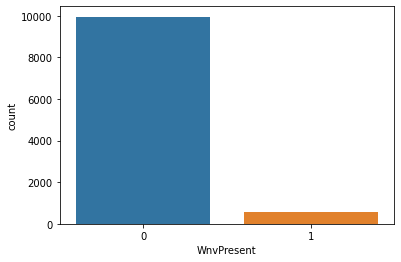

In [6]:
sns.countplot(data=train, x='WnvPresent');

The two classes, whether the West Nile Virus is present in the trap or not, are clearly unbalanced and they can be resampled to equalize the proportions.

In [7]:
# Total types of species
train['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

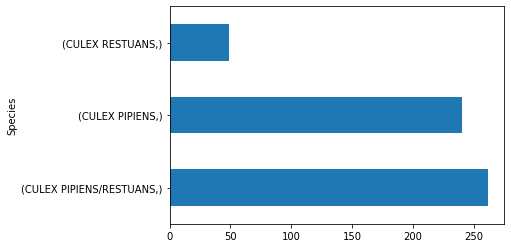

In [8]:
# Species that spread the virus
train[train['WnvPresent'] == 1][['Species']].value_counts().plot(kind='barh');

Only three species of the mosquitoes can actually transmit the virus. These can be One-Hot encoded into boolean columns and use to train the model.

In [9]:
# check for missing data
train.isna().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

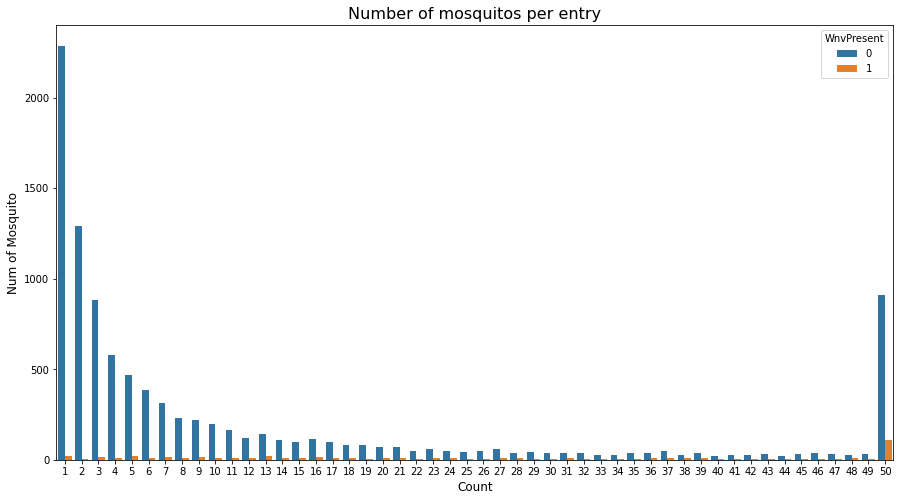

In [10]:
plt.figure(figsize=(15, 8))
plt.title("Number of mosquitos per entry", fontdict={'fontsize': 16})
sns.countplot(data=train, x='NumMosquitos', hue='WnvPresent')
plt.xlabel('Count', fontdict={'fontsize': 12})
plt.ylabel('Num of Mosquito', fontdict={'fontsize': 12});

As mentioned in the data dictionary, the number of mosquitoes are capped at 50 for each data entry, and that's why we see a huge number of rows for 50. We can group by trap and see the distribution again. This also highlights the fact that the way in which the data is organized, it creates the impression that if the number of mosquitos in the trap on a day is 50, it has higher likelihood of detecting the virus in the trap than any other trap. This is obviously not right and we might not be able to use the `NumMosquitos` as a feature. Additionally, the only info we have is `WnvPresent` and it has seemingly nothing to do with the number of mosquitos present in the trap, which can be verfied in the plot below.

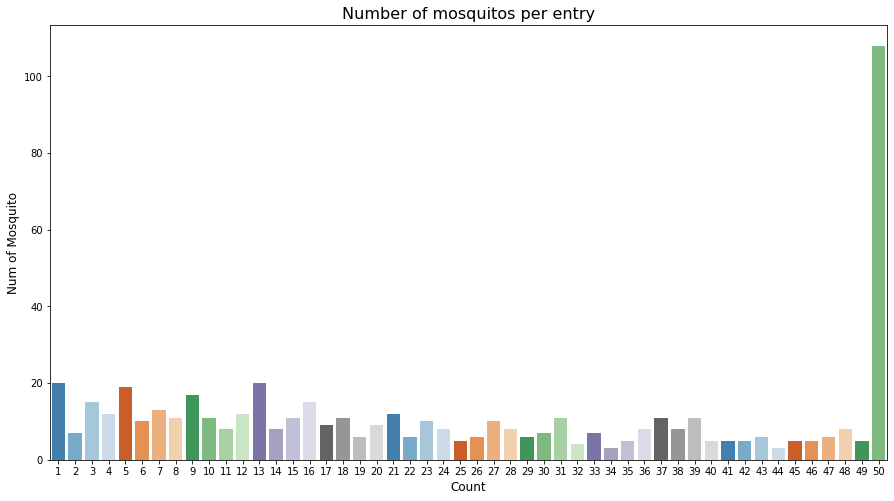

In [11]:
# plot only the number of mosquitos in trap if the virus was detected
plt.figure(figsize=(15, 8))
plt.title("Number of mosquitos per entry", fontdict={'fontsize': 16})
sns.countplot(data=train[train['WnvPresent'] == 1], x='NumMosquitos', palette='tab20c')
plt.xlabel('Count', fontdict={'fontsize': 12})
plt.ylabel('Num of Mosquito', fontdict={'fontsize': 12});

The above plot confirms that there is no obvious trend between the virus being detected in the trap and the number of mosquitos in that trap, except at 50, which is because the data entries are capped.

In [12]:
train.groupby(['Date', 'Species','Trap']).agg({
    'NumMosquitos': 'sum',
    'WnvPresent': 'max'
})

NumMosquitos  WnvPresent
Date       Species                Trap                          
2007-05-29 CULEX PIPIENS          T096             1           0
           CULEX PIPIENS/RESTUANS T002             1           0
                                  T015             1           0
                                  T048             1           0
                                  T050             1           0
...                                              ...         ...
2013-09-26 CULEX RESTUANS         T082             2           0
                                  T102             1           0
                                  T209             1           0
                                  T220             8           0
                                  T221             5           0

[8475 rows x 2 columns]

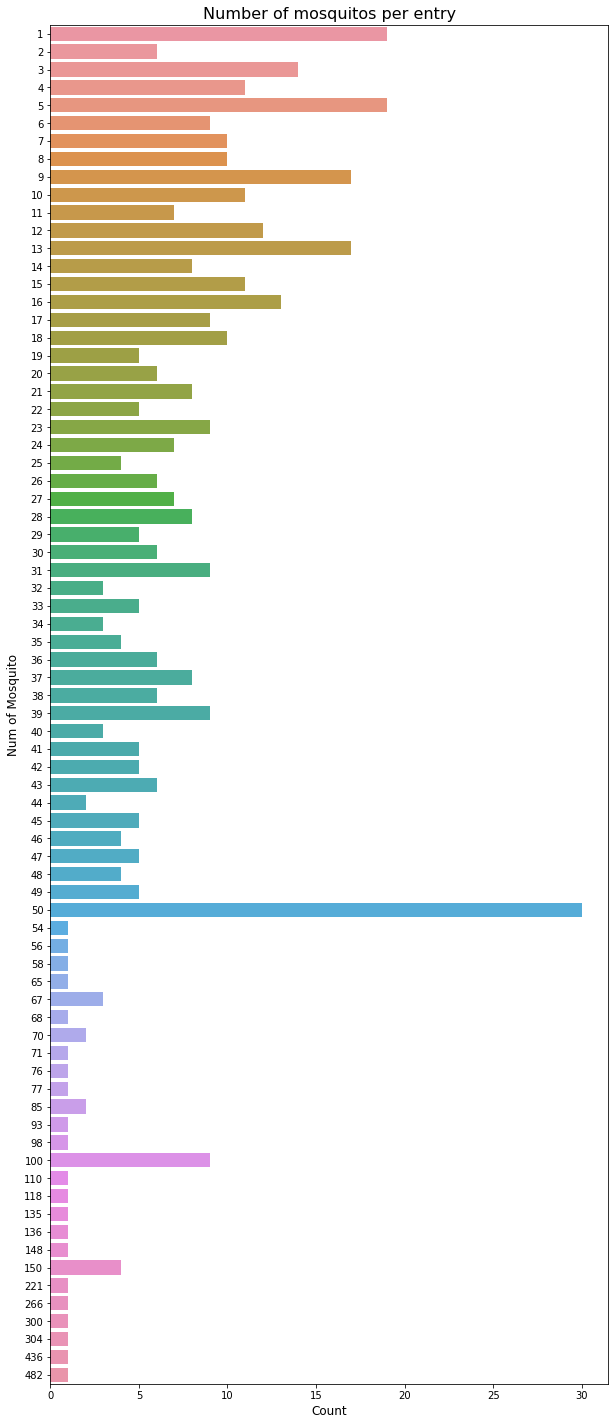

In [13]:
# plot the number of mosquitos per trap per day
plt.figure(figsize=(10, 25))
plt.title("Number of mosquitos per entry", fontdict={'fontsize': 16})
sns.countplot(
    data=train[train['WnvPresent'] == 1].groupby(
        ['Date', 'Species','Trap']).agg({
            'NumMosquitos': 'sum',
            'WnvPresent': 'max'
        }),
    y='NumMosquitos',
#     order=train[train['WnvPresent'] == 1].groupby(
#         ['Date', 'Species','Trap']).agg({
#             'NumMosquitos': 'sum',
#             'WnvPresent': 'max'
#         })[['NumMosquitos']].sort_values(by='NumMosquitos').values
)
plt.xlabel('Count', fontdict={'fontsize': 12})
plt.ylabel('Num of Mosquito', fontdict={'fontsize': 12});

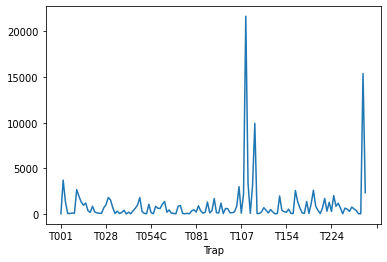

In [14]:
# lets see which traps have seen more mosquitos
train.groupby('Trap')['NumMosquitos'].sum().plot();

This plot doesn't necessarily give us much info because the traps are not arranged in any particular order across the city. We can perhaps look at the traps on a map.

In [15]:
# functions to get year and month from dates
def get_year(date):
    return date.year

def get_month(date):
    return date.month

In [ ]:
# convert the date to datetime type
train['Date'] = pd.to_datetime(train['Date'])

In [16]:
# Add the year and month columns
train['Year'] = train['Date'].apply(get_year)
train['Month'] = train['Date'].apply(get_month)

AttributeError: 'str' object has no attribute 'year'

In [ ]:
train['Trap'].nunique()

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Number of Mosquitos by Year", fontdict={'fontsize': 16})
sns.lineplot(data=train, x='Trap', y='NumMosquitos', hue='Year', ci=False)
plt.xticks([1, 50]);

Let's plot the trap locations and the traps where virus was detected.

In [ ]:
mapdata = np.loadtxt("../datasets//mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

plt.figure(figsize=(15, 15*aspect))
plt.title("Map showing trap locations", fontdict={'fontsize': 16})

# trap locations in latitude and longitudes
trap_loc = train.drop_duplicates('Trap')[['Trap','Longitude', 'Latitude', 'WnvPresent']]

# traps that have virus detected
trap_virus_present = trap_loc[trap_loc['WnvPresent'] > 0].groupby('Trap')[
                    ['WnvPresent']].mean().sort_values(by='WnvPresent', ascending=False)

df = pd.merge(trap_loc.drop(columns='WnvPresent'), trap_virus_present, on='Trap')

# to create the map boundaries
min_lon = trap_loc['Longitude'].min() - 0.05
max_lon = trap_loc['Longitude'].max() + 0.05
min_lat = trap_loc['Latitude'].min() - 0.025
max_lat = trap_loc['Latitude'].max() + 0.025

lon_lat_box = (min_lon, max_lon, min_lat, max_lat)

# all coordinates of traps
locations = trap_loc[['Longitude', 'Latitude']].drop_duplicates().values


plt.imshow(mapdata,
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect,
           alpha=0.6)

sns.kdeplot(data=df, x='Longitude', y='Latitude', fill=True, alpha=0.5)
plt.scatter(locations[:,0], locations[:,1], marker='x', s=150)
plt.scatter(df.values[:, 1], df.values[:, 2], marker='o', s=30)

for i in range(df.shape[0]):
    plt.text(df.values[i, 1], df.values[i, 2], df.values[i, 0], fontdict={'fontsize': 14})

plt.xlabel('Longitude', fontdict={'fontsize':12})
plt.ylabel('Latitude', fontdict={'fontsize':12})

plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat);

# ax[i].set_xticks([])
# ax[i].set_yticks([])

# Add this when copying to a script on Kaggle:
#plt.savefig('heatmap.png')

split by year

In [ ]:
# Code is borrowed from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap
mapdata = np.loadtxt("../datasets//mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15, 15*aspect), sharey=True, sharex=True)
# fig.suptitle("Traps with virus every year")

for i, year in enumerate(train['Year'].unique()):
    trap_loc = train[train['Year'] == year].drop_duplicates('Trap')[['Trap','Longitude', 'Latitude', 'WnvPresent']]

    trap_virus_present = trap_loc[trap_loc['WnvPresent'] > 0].groupby('Trap')[
                        ['WnvPresent']].mean().sort_values(by='WnvPresent', ascending=False)
    
    df = pd.merge(trap_loc.drop(columns='WnvPresent'), trap_virus_present, on='Trap')

    locations = trap_loc[['Longitude', 'Latitude']].drop_duplicates().values

    ax[i].imshow(mapdata,
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect,
               alpha=0.7)
    
    ax[i].scatter(locations[:,0], locations[:,1], marker='x', s=70)
    ax[i].scatter(df.values[:, 1], df.values[:, 2], marker='o', s=30) # , cmap='coolwarm'
    
    # for i in range(df.shape[0]):
    #     plt.text(df.values[i, 1], df.values[i, 2], df.values[i, 0])

    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    ax[i].title.set_text(year)
plt.tight_layout()
    
    # Add this when copying to a script on Kaggle:
    #plt.savefig('heatmap.png')

In [ ]:
plt.figure(figsize=(15, 8))
plt.title("West Nile virus detected month-wise", fontdict={'fontsize': 16})
sns.lineplot(data=train, x='Month', y='WnvPresent', hue='Year', ci=False, palette='tab10')
plt.xlabel('Month', fontdict={'fontsize': 12})
plt.ylabel('WnvPresent', fontdict={'fontsize': 12})
plt.xticks(ticks=[5, 6, 7, 8, 9, 10], labels=['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])
plt.yticks([]);

The above plot shows that the month of Aug is always the peak where virus is detected in the mosquito population. It would be interesting to see the weather changes during and before this time of year.

In [ ]:
# the species that spread the virus
species_interest = train[train['WnvPresent'] == 1]['Species'].unique()

# function to add binary columns for species that spread the virus
def get_species_cols(df):
    for species in species_interest:
        df['Species_'+species] = df['Species'].apply(lambda x: 1 if x == species else 0)
    df['Species_other'] = df['Species'].apply(lambda x: 1 if x not in species_interest else 0)
    
    # return the df
    return df

In [ ]:
train = get_species_cols(train)

In [ ]:
# Add a station column to train based on which trap location is near to weather station
# function to get the weather station nearest to the trap
def get_station(trap):
    if trap not in trap_loc['Trap']:
        return 1
    # get the station coordinates from the data dictionary
    station_1 = (41.995, -87.933)
    station_2 = (41.786, -87.752)
    
    lat = trap_loc[trap_loc['Trap'] == trap][['Latitude', 'Longitude']].values[0][0]
    lon = trap_loc[trap_loc['Trap'] == trap][['Latitude', 'Longitude']].values[0][1]
    
    # calculate the distance of trap from each weather station
    trap_distance_1 = geopy.distance.distance(station_1, (lat, lon))
    trap_distance_2 = geopy.distance.distance(station_2, (lat, lon))
    
    return 1 if trap_distance_1 < trap_distance_2 else 2

In [ ]:
# create the station column
train['Station'] = train['Trap'].apply(get_station)

In [ ]:
train.duplicated().sum()

As we see, there are 813 rows that are duplicates in the train dataset. These are because the `NumMosquitos` are truncated at 50 for each row. Let's check if the same is true for test dataset.

In [ ]:
test.drop(columns='Id').duplicated().sum()

Even the test data has 1533 duplicated rows. This shows that there is a chance of data corruption or leaking because the duplicated rows means the same thing done for train date (truncating each entry at 50) is done for test data as well. In reality, this can never be known in advance. Since we are not including the `NumMosquitos` in our model training, we can include the number of duplicated row each day for each trap so as to have an 'indirect' account for the `NumMosquitos` feature.

In [ ]:
# write a function to create the column for number of duplicated rows
def get_duplicate_rows(df):
    return df.groupby(['Date', 'Species', 'Trap'])['NumMosquitos'].count().sort_values().values

Spray data

In [ ]:
spray.shape

In [ ]:
spray['Date'].unique()

In [ ]:
spray['Date'] = pd.to_datetime(spray['Date'])

In [ ]:
spray['Year'] = spray['Date'].apply(get_year)
spray['Month'] = spray['Date'].apply(get_month)

There are only 2 dates in 2011 and 8 dates in 2013 on which the city has some spray data on. The spray is supposed to reduce the growth/population of the mosquito, as cited [here](https://www.cdc.gov/westnile/vectorcontrol/aerial-spraying.html). Let's see if that is what actually happens.

In [ ]:
# plot the 2011 number of mosquito count with spray dates
def plot_spray_data(year):
    plt.figure(figsize=(15, 5))
    plt.title(f"Number of Mosquitos in {year} with spray dates", fontdict={'fontsize': 16})
    plt.plot(train[train['Year'] == year].groupby('Date')['NumMosquitos'].sum())
    for date in spray[spray['Year'] == year]['Date'].unique():
        plt.axvline(x=date, ls='--', color='k')

In [ ]:
plot_spray_data(2011)

In [ ]:
plot_spray_data(2013)

As we can see from the two plots, it cannot be conclusively said that the spraying had any direct effect on the mosquito population. Although, it must be noted that these are the total number of mosquitos and it would make sense to plot the spray data vs mosquito population based on location where it was sprayed.

In [ ]:
test.shape

In [ ]:
test['Date'] = pd.to_datetime(test['Date'])

In [ ]:
test['year'] = test['Date'].apply(get_year)
test['month'] = test['Date'].apply(get_month)

In [ ]:
test = get_species_cols(test)

In [ ]:
set(test['Trap'].unique()) ^ set(train['Trap'].unique())

We found out that the test data has some traps which the train data does not have. Most of these are the satellite traps which are located near the original trap.

In [ ]:
test['Station'] = test['Trap'].apply(get_station)

Weather

In [ ]:
weather.head()

In [ ]:
weather.isnull().sum()

In [ ]:
weather.shape

In [ ]:
weather['Date'] = pd.to_datetime(weather['Date'])

In [ ]:
# replace all missing data with NaNs
for col in weather.columns:
    weather[col].replace('M', np.nan, inplace=True)
    weather[col].replace('-', np.nan, inplace=True)
    weather[col].replace(' ', 'moderate', inplace=True)
    weather[col].replace('  T', 0.005, inplace=True)

In [ ]:
weather['Tavg'].fillna(((weather['Tmax'] + weather['Tmin'])/2),inplace=True)

In [ ]:
weather['PrecipTotal'].fillna(0, inplace=True)
weather['Heat'].fillna(0, inplace=True)
weather['Cool'].fillna(0, inplace=True)
weather.loc[2412, 'WetBulb'] = weather.loc[2413, 'WetBulb']
weather.loc[2415, 'WetBulb'] = weather.loc[2414, 'WetBulb']
weather.loc[2410, 'WetBulb'] = weather.loc[2411, 'WetBulb']
weather.loc[848, 'WetBulb'] = weather.loc[849, 'WetBulb']

In [ ]:
# convert objects to numeric type
cols_to_floats = ['PrecipTotal']
cols_to_int = ['WetBulb', 'Tavg', 'Heat', 'Cool', 'DewPoint', 'WetBulb']
for col in weather.columns:
    if col in cols_to_floats:
        weather[col] = weather[col].astype(float)
    elif col in cols_to_int:
        weather[col] = weather[col].astype(int)

In [ ]:
weather.dtypes

The columns we are using `Tavg`, `DewPoint`, `WetBulb`, `Heat`, `Cool`, `PrecipTotal`, `Latitude`, `Longitude`

In [ ]:
weather_clean = weather[['Date', 'Station', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal']]

In [ ]:
weather_clean.to_csv('../datasets/weather_clean.csv')

In [ ]:
train_weather_merged = pd.merge(train, weather_clean, on=['Date', 'Station'], how='left')

In [ ]:
drop_cols = ['Address', 'Species', 'Trap', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy', 'Station']
train_clean = train_weather_merged.drop(columns=drop_cols)

In [ ]:
train_clean.to_csv('../datasets/train_clean.csv')

In [ ]:
test_weather_merged = pd.merge(test, weather_clean, on=['Date', 'Station'], how='left')

In [ ]:
test_clean = test_weather_merged.drop(columns=drop_cols)

In [ ]:
test_clean.to_csv('../datasets/test_clean.csv')